In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from dataloader import DriverDataset
import pandas as pd
import pdb
import os

%load_ext autoreload
%autoreload 2

os.environ["OMP_NUM_THREADS"] = "4" # prevent memory leak in minibatch kmeans

In [4]:
# load image data
# mnist data
# mnist_load = pd.read_csv('../toy_data/mnist.csv')
# mnist = mnist_load.drop(columns='label')/255
# print(mnist.shape)
# data = mnist

# driver dataset
#>TODO: not shuffling the data set places different subjects in the training and test dataset, and the clustering models
# perform very poorly. This means the model fails to generalize to other subjects.
dataset = DriverDataset(shuffle=True)

      subject classname            img
10300    p039        c2  img_70729.jpg
7510     p024        c5  img_94974.jpg
4510     p021        c0  img_29923.jpg
11468    p042        c1   img_7149.jpg
21354    p075        c6  img_25763.jpg
...       ...       ...            ...
19336    p064        c9  img_87536.jpg
4667     p021        c2  img_51277.jpg
6646     p022        c8  img_10273.jpg
7118     p024        c2  img_50755.jpg
610      p002        c7  img_27403.jpg

[22424 rows x 3 columns]


In [16]:
# split training and testing data
#mnist
# labels = mnist_load.iloc[:,0]
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, random_state=0)

# driver dataset
gray = True
edges = True
np.random.seed(0)
train_data, test_data = dataset.split_dataset(17777)
n_train = train_data[0].shape[0]
n_test = test_data[0].shape[0]
X_train, people_train, y_train = dataset.make_batch(train_data, n_train, gray=gray, edges=edges)
X_test, people_test, y_test = dataset.make_batch(test_data, n_test, gray=gray, edges=edges)

In [17]:
# flatten image data
if (not gray):
    N, H, W, C = X_train.shape
    X_train = np.reshape(X_train, (N, H*W*C))    
    X_test = np.reshape(X_test, (X_test.shape[0], H*W*C))
else:
    N, H, W = X_train.shape
    X_train = np.reshape(X_train, (N, H*W))
    X_test = np.reshape(X_test, (X_test.shape[0], H*W))

(17777, 3072)
(17777,)
fitting batch 0/16


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fitting batch 1/16
fitting batch 2/16
fitting batch 3/16
fitting batch 4/16
fitting batch 5/16
fitting batch 6/16
fitting batch 7/16
fitting batch 8/16
fitting batch 9/16
fitting batch 10/16
fitting batch 11/16
fitting batch 12/16
fitting batch 13/16
fitting batch 14/16
fitting batch 15/16


Text(0.5, 1.0, 'PCA explained variance ratio')

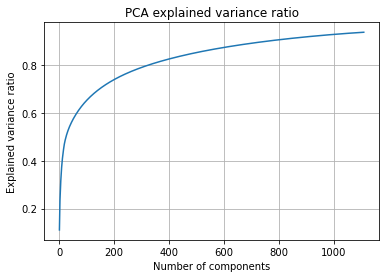

In [18]:

# pca = PCA(n_components=data.shape[1])
# pca.fit(data)

# do incremental fit
print(X_train.shape)
print(y_train.shape)
N = X_train.shape[0]
n_batch = 16 # tune this based on available memory
num_samples = int(np.floor(N/n_batch))
pca = IncrementalPCA(n_components=num_samples)
ind = 0
for i in range(0, n_batch):
    print('fitting batch {}/{}'.format(i, n_batch))
    if (ind+num_samples > X_train.shape[0]):
        X_batch = X_train[ind:,:]
    else:
        X_batch = X_train[ind:ind+num_samples,:]
#     y_batch = y_train[ind:ind+num_samples,:]
    pca.partial_fit(X_batch)
    ind += num_samples
# pca.fit(X_train)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('PCA explained variance ratio')

In [19]:
# get best number of components
n_comp_pca = 300 # tune this number

# apply PCA with reduced number of components
pca_red = IncrementalPCA(n_components=n_comp_pca) # using a set number of components
# X_train_pca_red = np.empty((X_train.shape[0], n_comp_pca))
# X_test_pca_red = np.empty((X_test.shape[0], n_comp_pca))
# X_train_pca_recovered = np.empty(X_train.shape)
# ind = 0
# for i in range(0, n_batch):
#     print('fitting batch {}/{}'.format(i, n_batch))
#     if (ind+num_samples > X_train.shape[0]):
#         X_train_batch = X_train[ind:,:]
#     else:
#         X_train_batch = X_train[ind:ind+num_samples,:]
#     pca.partial_fit(X_batch)
#     ind += num_samples
X_train_pca_red = pca_red.fit_transform(X_train)
X_test_pca_red = pca_red.transform(X_test)
X_train_pca_recovered = pca_red.inverse_transform(X_train_pca_red)
print(X_train_pca_red.shape)
print(X_test_pca_red.shape)
print(X_train_pca_recovered.shape)

(17777, 300)
(4647, 300)
(17777, 3072)


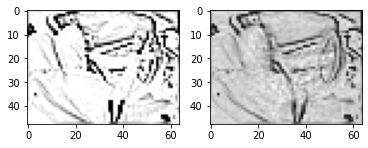

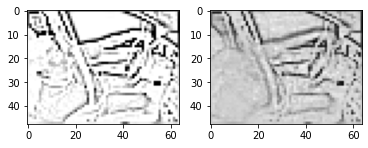

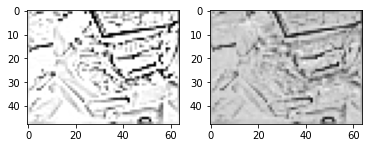

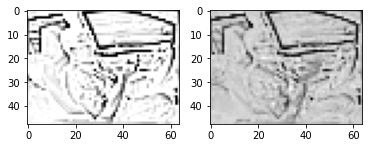

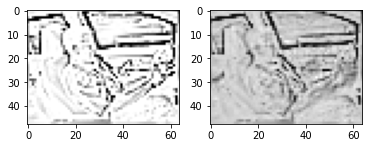

In [20]:
# compare original and compressed test images
X_test_pca_recovered = pca_red.inverse_transform(X_test_pca_red)
for i in range(0, 5):
    f, axarr = plt.subplots(1, 2)
    if (gray):
        img_pca = X_test_pca_recovered[i,:].reshape((H, W))
        img_orig = X_test[i,:].reshape((H, W))
    else:
        img_pca = X_test_pca_recovered[i,:].reshape((H, W, C))
    #     img_orig = X_train.iloc[i].values.reshape((H, W, C))    
        img_orig = X_test[i,:].reshape((H, W, C))
    axarr[0].imshow(img_orig, cmap='gray_r')
    axarr[1].imshow(img_pca, cmap='gray_r')

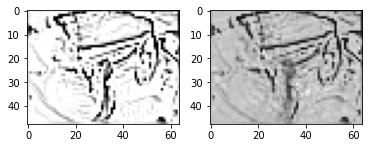

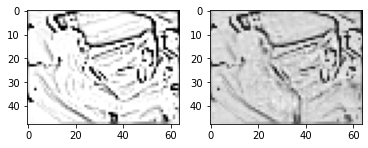

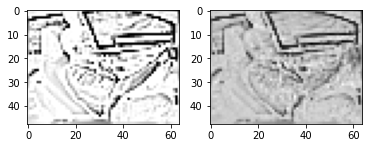

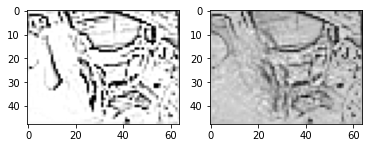

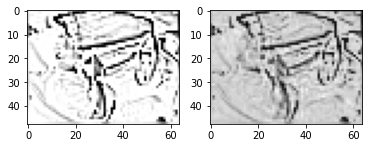

In [21]:
# compare original and compressed training images
for i in range(0, 5):
    f, axarr = plt.subplots(1, 2)
    if (gray):
        img_pca = X_train_pca_recovered[i,:].reshape((H, W))
        img_orig = X_train[i,:].reshape((H, W))
    else:
        img_pca = X_train_pca_recovered[i,:].reshape((H, W, C))
    #     img_orig = X_train.iloc[i].values.reshape((H, W, C))    
        img_orig = X_train[i,:].reshape((H, W, C))
    axarr[0].imshow(img_orig, cmap='gray_r')
    axarr[1].imshow(img_pca, cmap='gray_r')

In [22]:
# k means clustering
def kmeans_predict(k, X_train_pca_red, y_train, X_test_pca_red, y_test):
    '''
    Returns predicted labels for the training and test data set for a given number of clusters k
    '''
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, max_iter=300).fit(X_train_pca_red)
    print(k)
#     kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train_pca_red)

    # associate kmeans clusters with labels
    y_train_pred = kmeans.labels_
    reference_labels = {}
    for i in np.unique(y_train_pred):    
        index = np.where(y_train_pred == i,1,0)        
        num = np.bincount(y_train[index==1]).argmax()    
        reference_labels[i] = num

    # use clusters on test data
    y_test_pred = kmeans.predict(X_test_pca_red)
    print(all(np.isin(y_test_pred, y_train_pred)))

    # apply relabeling
    for i in range(0, len(y_train_pred)):
        y_train_pred[i] = reference_labels[y_train_pred[i]]
    for i in range(0, len(y_test_pred)):        
        y_test_pred[i] = reference_labels[y_test_pred[i]]
        
    return y_train_pred, y_test_pred       
    

In [23]:
def metrics_kmeans(y_pred, y_true, confusion=False):    
    #@TODO: roc_auc score?
    kmeans_accuracy = accuracy_score(y_pred, y_true)
    cm = None
    if (confusion):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
    return kmeans_accuracy, cm

C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


3
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


53
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


103
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


153
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


203
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


253
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


303
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


353
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


403
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


453
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


503
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


553
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


603
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


653
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


703
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


753
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


803
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


853
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


903
True


C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


953
True


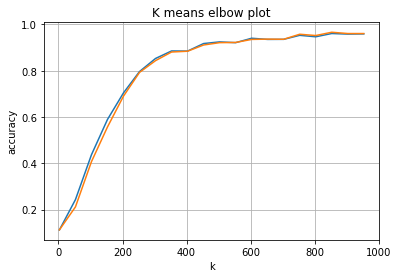

In [24]:
# Use elbow method to determine best k
test_k = np.arange(3, 1000, 50)
acc_train_arr = np.empty((test_k.size))
acc_test_arr = np.empty((test_k.size))
for i in range(0, test_k.size):
#     y_train_pred, y_test_pred = kmeans_predict(test_k[i], X_train_pca_red, y_train, X_test_pca_red, y_test)
    y_train_pred, y_test_pred = kmeans_predict(test_k[i], X_train, y_train, X_test, y_test)
    acc_train, cm_train = metrics_kmeans(y_train_pred, y_train)
    acc_test, cm_test = metrics_kmeans(y_test_pred, y_test)
    acc_train_arr[i] = acc_train
    acc_test_arr[i] = acc_test
    
plt.plot(test_k, acc_train_arr, label='training accuracy')
plt.plot(test_k, acc_test_arr, label='test accuracy')
plt.title('K means elbow plot')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.grid()

In [29]:
best_k = 300 # tune this
y_train_pred, y_test_pred = kmeans_predict(best_k, X_train_pca_red, y_train, X_test_pca_red, y_test)
# y_train_pred, y_test_pred = kmeans_predict(best_k, X_train, y_train, X_test, y_test)

C:\Users\Alan Hesu\miniconda3\envs\ml_proj\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


300
True


training accuracy: 0.8977330258198796, testing accuracy 0.8967075532601678


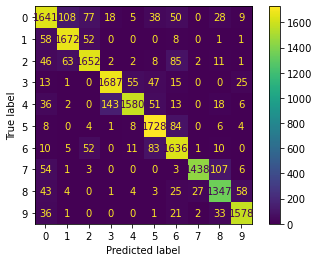

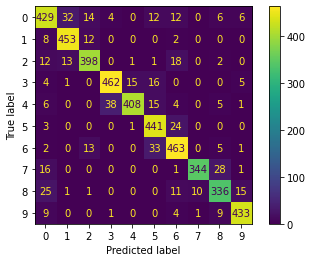

In [30]:
# create confusion matrix from kmeans results
# training accuracy

kmeans_acc_train, cm_train = metrics_kmeans(y_train_pred, y_train, confusion=True)
kmeans_acc_test, cm_test = metrics_kmeans(y_test_pred, y_test, confusion=True)
    
print('training accuracy: {}, testing accuracy {}'.format(kmeans_acc_train, kmeans_acc_test))
